In [1]:
import numpy as np

import adaptive_latents
from adaptive_latents import AnimationManager, Pipeline, CenteringTransformer, proSVD, Bubblewrap, VanillaOnlineRegressor, NumpyTimedDataSource, KernelSmoother
import adaptive_latents.input_sources.datasets as datasets
import adaptive_latents.plotting_functions as pf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import copy


## Intro video

/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)


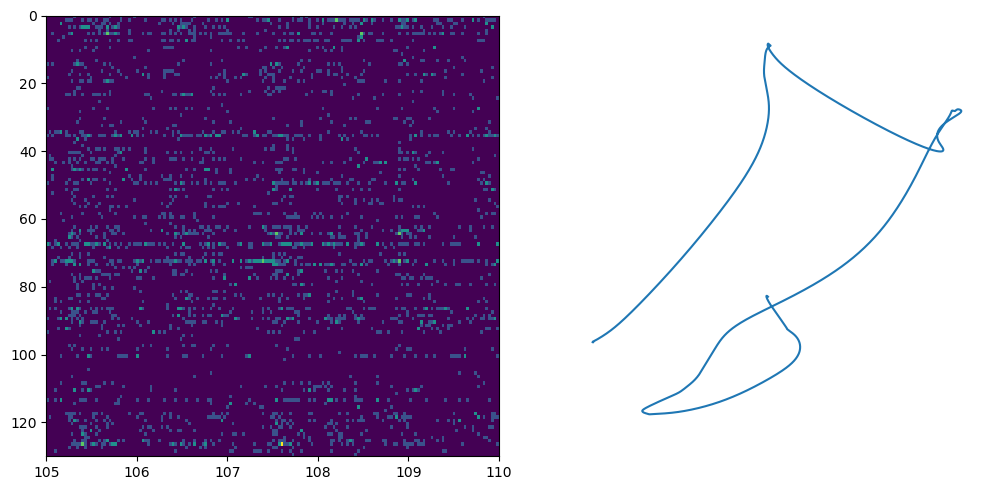

In [15]:
d = datasets.Odoherty21Dataset()

tail_length = 5  # seconds

with AnimationManager(n_cols=2, n_rows=1, figsize=(10, 5)) as am:
    for current_t in np.linspace(100, 110, 51):
        am.axs[0,0].cla()

        n_columns = np.floor(tail_length / d.bin_width).astype(int)
        idx = np.nonzero(~(d.neural_data.t < current_t))[0][0]
        
        
        am.axs[0,0].imshow(d.neural_data.a[idx-n_columns:idx,0,:].T, aspect='auto', interpolation='none', extent=[current_t - tail_length, current_t, d.neural_data.a.shape[2], 0])



        old_lims = am.axs[0,1].axis()
        am.axs[0,1].cla()
        am.axs[0,1].axis('off')
        
        s = ((current_t - tail_length) < d.behavioral_data.t) & (d.behavioral_data.t < current_t)
        am.axs[0,1].plot(d.behavioral_data.a[s,0,0], d.behavioral_data.a[s,0,1])
        pf.use_bigger_lims(am.axs[0,1], old_lims)
        
        am.grab_frame()

## Regression video

  0%|          | 0/520 [00:00<?, ?it/s]

/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


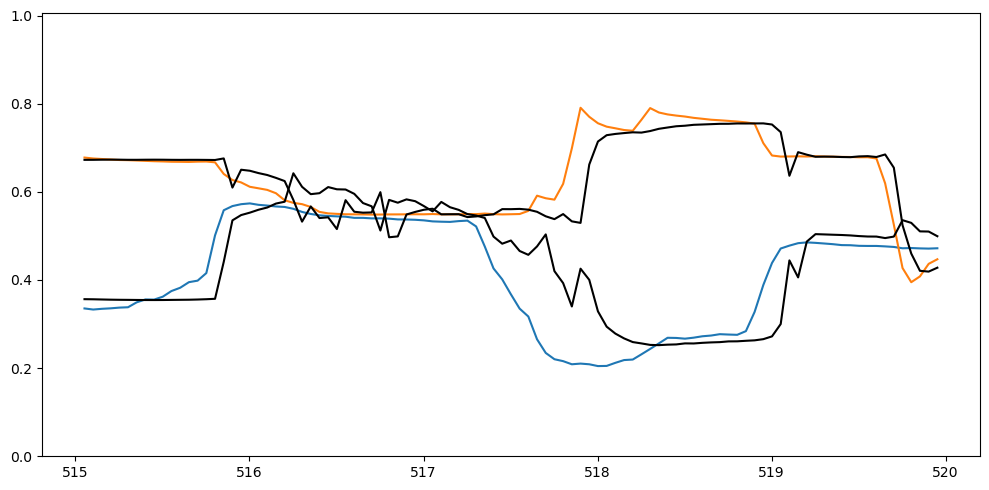

In [14]:
d = datasets.Temmar24uDataset()

bw = Bubblewrap(
    num=100,
    eps=1e-3,
    step=1,
    num_grad_q=3,
)
reg = VanillaOnlineRegressor()

p = Pipeline([
    # proSVD(k=6),
    # KernelSmoother(tau=0.2/d.bin_width),
    bw,
    reg
])
iterator = p.streaming_run_on([(copy.copy(d.behavioral_data), 1), (copy.copy(d.behavioral_data),0)], return_output_stream=True)

time_between_draws = .1
time_of_last_draw = 500
exit_time = 520
prediction = []
prediction_t = []
pbar = tqdm(total=exit_time)

with AnimationManager(n_cols=1, n_rows=1, figsize=(10, 5)) as am:
    ax = am.axs[0,0]
    ax.text(.01, .01, "\n".join([f"{k}: {v}" for k, v in p.get_params().items()]), transform=ax.transAxes, fontsize='xx-small', wrap=True)
    am.grab_frame()
    
    for output, stream in iterator:
        current_ts = [s[0].current_sample_time() for s in p.mid_run_sources]
        current_ts = list(filter(lambda x: x is not None, current_ts))
        current_t = max(current_ts) if len(current_ts) else 0
        assert current_t == output.t
        pbar.update(current_t - pbar.n)

        if stream == 1 and current_t > time_of_last_draw - 10:
            time_to_predict = bw.last_timepoint + .1
            output = reg.predict(bw.get_alpha_at_t(time_to_predict)) # todo: why doesn't transform work?
            prediction.append(output)
            prediction_t.append(current_t)

        if current_t > time_of_last_draw + time_between_draws:
            old_axes = ax.axis()
            ax.cla()

            s = (current_t-5 < d.behavioral_data.t) & (d.behavioral_data.t < current_t)
            ax.plot(d.behavioral_data.t[s], d.behavioral_data.a[s,0,0])
            ax.plot(d.behavioral_data.t[s], d.behavioral_data.a[s,0,1])

            if len(prediction):
                pt = np.array(prediction_t)
                s = (current_t-5 < pt) & (pt < current_t)
                pred = np.squeeze(prediction)[s]
                ax.plot(pt[s], pred[:, 0], 'k')
                ax.plot(pt[s], pred[:, 1], 'k')

            pf.use_bigger_lims(ax, old_axes, x=False)
            am.grab_frame()
            time_of_last_draw = current_t

        if current_t > exit_time:
            break



In [11]:
bw.last_timepoint

In [67]:
p = Pipeline()
for o in p.streaming_run_on([['a', 'b', 'c'], ['x', 'y', 'z']]):
    s0 = p.mid_run_sources[0][0]
    s1 = p.mid_run_sources[1][0]
    print(f'{o}, t={o.t}, {s0.current_time} {s1.current_time}')



a, t=0, 0 None
x, t=0, 0 0
b, t=1, 1 0
y, t=1, 1 1
c, t=2, 2 1
z, t=2, 2 2
